In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
from frontend import solve, evaluate
import mls as md
import fw

## Warehouse

We first generate some (artificial) data records and distribute them as an RDD. If you have already a correctly prepared RDD, then skip this step.

In [2]:
# X: n*p  W: p*m  Y: n*m
# =======================

# parameters
metadata = {'n':1000, 'm':100, 'p':100, 'r':10, 'nn':1, 'seed':0}
partition = 8  # >= number of cores

# generate data
data, W = md.generate(**metadata)

# prepare data
points = mat2point(*data)
dataRDD = sc.parallelize(points, partition)

## Optimization

We use the `solve` function from the `frontend` module to solve the minimization problem. It returns a Frank-Wolfe solution path, which is simply the set of singular vectors and step sizes it chooses during the optimization.

The following uses DFW-Trace-log as linear optimization oracle and the line search size.

In [3]:
# parameter
nn = 1      # trace norm constraint
T = 20      # Epochs
lmo = lambda rdd, **kwargs: fw.poweriter(rdd, lambda t: fw.loground(t, c=1), 'random', **kwargs)  # powlog
step = fw.linesearch    # use line search step size

In [4]:
# Feed the RDD (of records) and other information to `solve`
path = solve(dataRDD, metadata, md, nn, T, lmo, step)

## Evaluation

We use the `evaluate` function from the `frontend` module to evalute the objective function, the estimation error and/or the missclassification error. See its implementation to get a quick idea of obtaining the FW solution from its path.

In [5]:
# Evaluate the objective function value and the estimation error
loss, eerr, _ = evaluate(dataRDD, path, metadata, md, W)

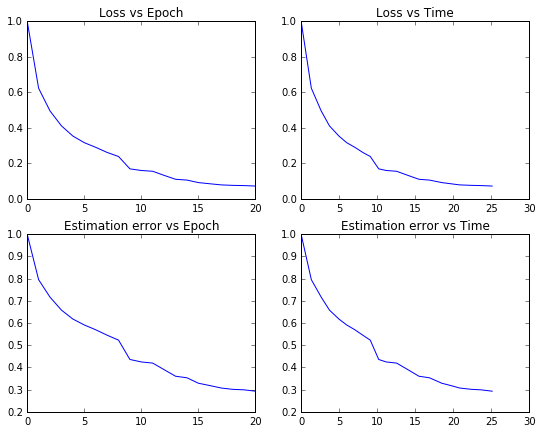

In [6]:
plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.plot(loss)
plt.title('Loss vs Epoch')
plt.subplot(222)
plt.plot(path.timer, loss)
plt.title('Loss vs Time')
plt.subplot(223)
plt.plot(eerr)
plt.title('Estimation error vs Epoch')
plt.subplot(224)
plt.plot(path.timer, eerr)
plt.title('Estimation error vs Time')

The values decrease nicely.